In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [6]:
dados_ipea = pd.read_csv("ipea.csv",sep=",")

In [7]:
dados_ipea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11088 entries, 0 to 11087
Data columns (total 2 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Data                                  11088 non-null  object 
 1   Preço - petróleo bruto - Brent (FOB)  11088 non-null  float64
dtypes: float64(1), object(1)
memory usage: 173.4+ KB


In [8]:
dados_ipea["Data"] = pd.DatetimeIndex(dados_ipea["Data"])
dados_ipea.set_index("Data",inplace = True)
dados_ipea.head()

,Preço - petróleo bruto - Brent (FOB)
Data,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [9]:
decompose_add = seasonal_decompose(dados_ipea, period=1)

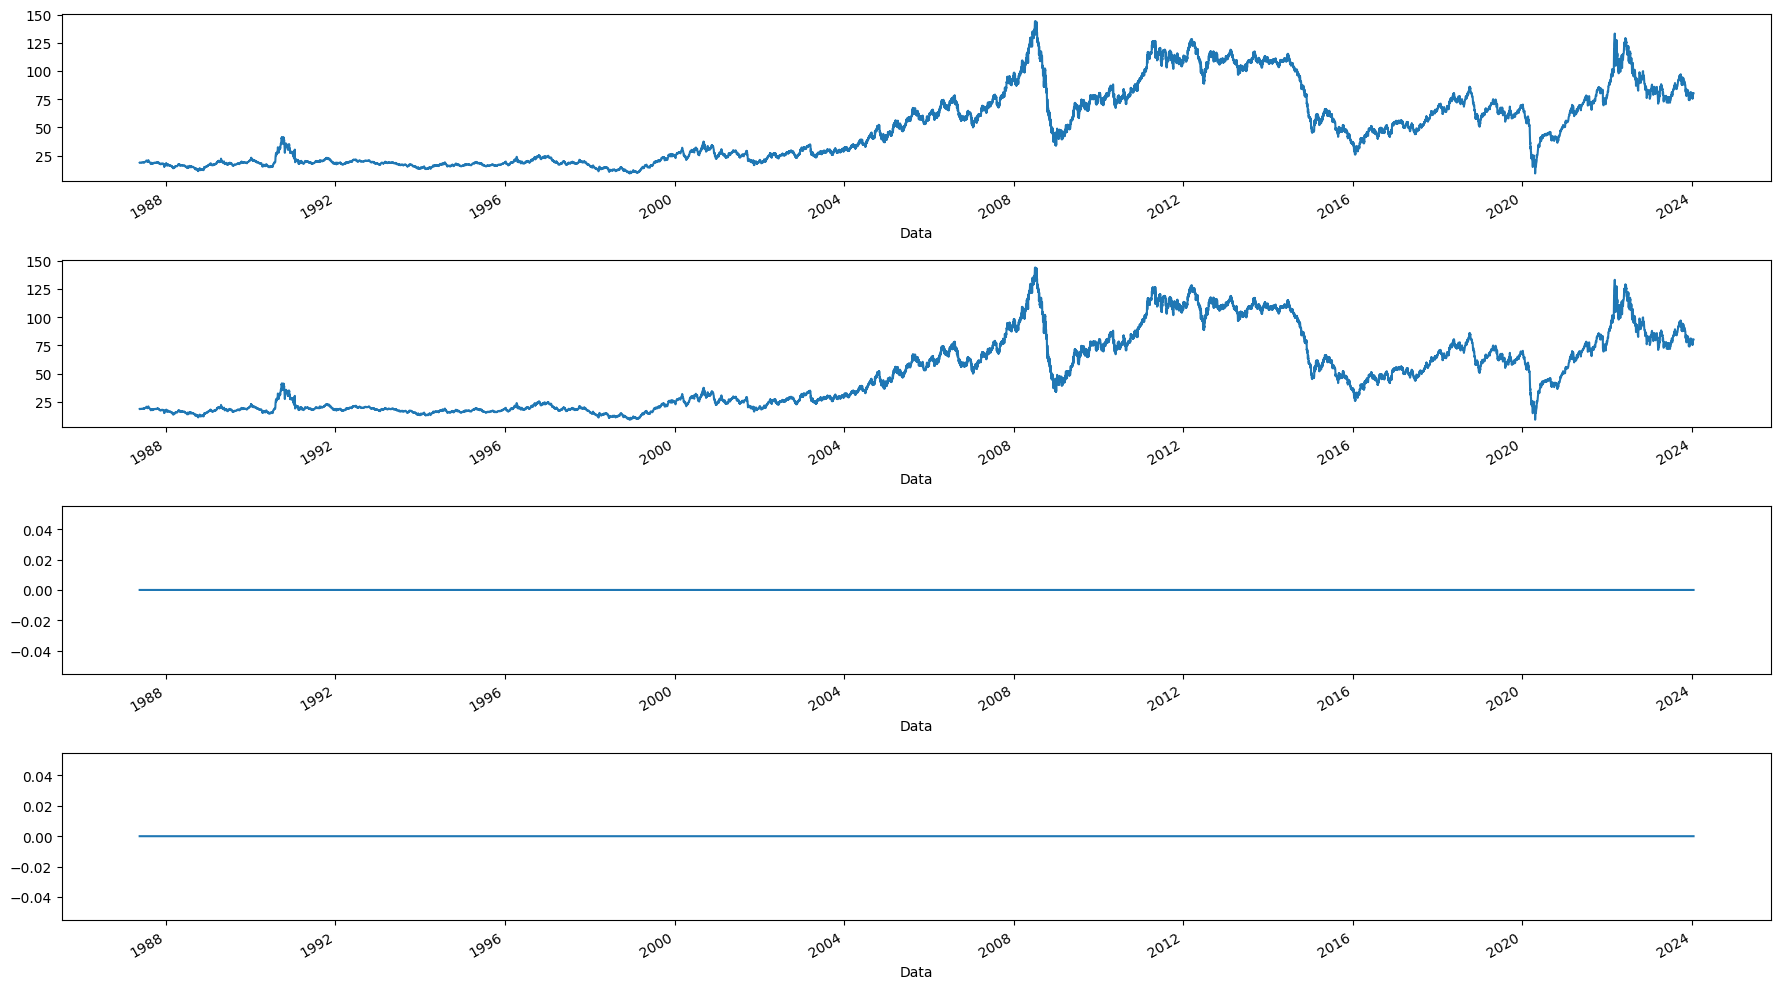

In [10]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (18,10))

decompose_add.observed.plot(ax=ax1)
decompose_add.trend.plot(ax=ax2)
decompose_add.seasonal.plot(ax=ax3)
decompose_add.resid.plot(ax=ax4)

plt.tight_layout()

In [23]:
from statsmodels.tsa.holtwinters import Holt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import math
def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

In [13]:
ipea_res = dados_ipea.resample('1W').ffill()
ipea_res

,Preço - petróleo bruto - Brent (FOB)
Data,
1987-05-24,18.55
1987-05-31,18.58
1987-06-07,18.65
1987-06-14,18.78
1987-06-21,19.05
...,...
2023-12-24,80.23
2023-12-31,77.69
2024-01-07,78.31


In [44]:
treino = ipea_res.loc[:'2023-06-30']
test = ipea_res.loc['2023-07-01':]

In [32]:
print(treino.shape)
print(test.shape)

(1884, 1)
(30, 1)


In [45]:
treino

,Preço - petróleo bruto - Brent (FOB)
Data,
1987-05-24,18.55
1987-05-31,18.58
1987-06-07,18.65
1987-06-14,18.78
1987-06-21,19.05
...,...
2023-05-28,76.33
2023-06-04,76.00
2023-06-11,74.74


In [59]:
modelo_holt = Holt(treino)

In [62]:
holt = modelo_holt.fit()

In [63]:
holt.summary()

Dep. Variable:,Preço - petróleo bruto - Brent (FOB),No. Observations:,1884
Model:,Holt,SSE,13616.246
Optimized:,True,AIC,3734.300
Trend:,Additive,BIC,3756.465
Seasonal:,None,AICC,3734.345
Seasonal Periods:,None,Date:,"Sun, 28 Jan 2024"
Box-Cox:,False,Time:,22:44:54
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
smoothing_trend,0.0001,beta,True


In [64]:
holt_prev = holt.forecast(len(test))

In [65]:
holt_prev.shape

(30,)

In [80]:
holt_prev.mean()

74.0380836924657

In [38]:
mae_holt = mean_absolute_error(test["Preço - petróleo bruto - Brent (FOB)"].values, holt_prev.values)
mse_holt = mean_squared_error(test["Preço - petróleo bruto - Brent (FOB)"].values, holt_prev.values)
rmse_holt = math.sqrt(mse_holt)
mape_holt = mean_absolute_percentage_error(test["Preço - petróleo bruto - Brent (FOB)"].values, holt_prev.values)
wmape_holt = wmape(test["Preço - petróleo bruto - Brent (FOB)"].values, holt_prev.values)

print(f"MAE: {mae_holt:.5f}")
print(f"MSE: {mse_holt:.5f}")
print(f"RMSE: {rmse_holt:.5f}")
print(f"MAPE: {mape_holt:.2%}")
print(f"WMAPE: {wmape_holt:.2%}")

MAE: 10.51925
MSE: 152.73467
RMSE: 12.35859
MAPE: 11.94%
WMAPE: 12.44%


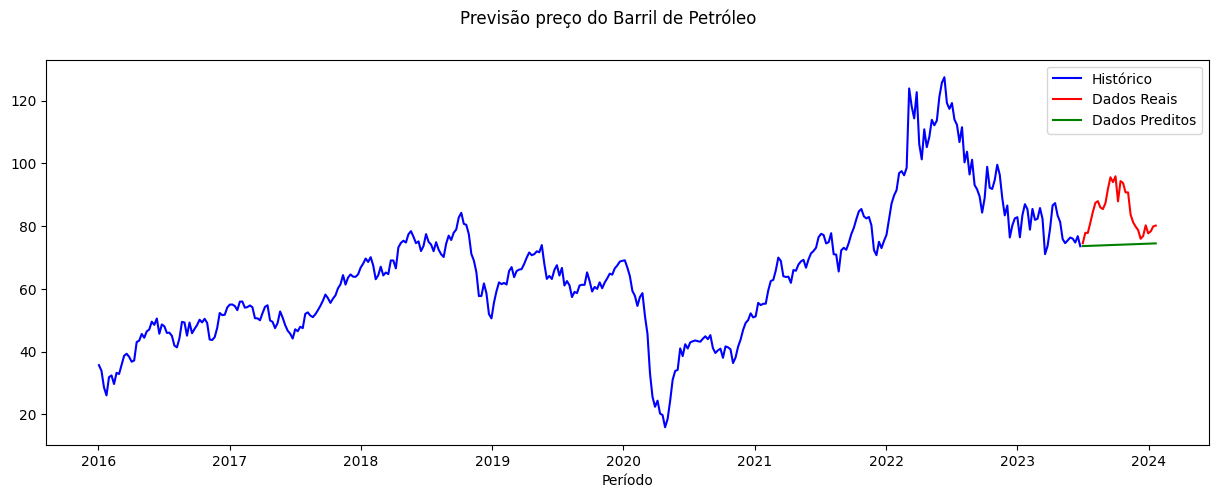

In [54]:
fig, ax = plt.subplots(figsize = (15,5))
fig.suptitle('Previsão preço do Barril de Petróleo')

df_treino, = plt.plot(treino.loc['2016-01-01':],"b", label = "Histórico")
df_test, = plt.plot(test, "r", label = "Dados Reais")
df_prev, = plt.plot(holt_prev, "g", label = "Dados Preditos")
plt.legend(handles=[df_treino, df_test, df_prev])
plt.xlabel('Período')
plt.show()

In [71]:
import joblib
joblib.dump(modelo_holt, 'holt.joblib')

['holt.joblib']

In [85]:
def holt_pred(periodo_previsao):
    # Carregando o modelo
    holt = joblib.load('holt.joblib')

    # Prevendo de acordo com o filtro
    holt_results= holt.fit()
    forecast_holt = holt_results.forecast(periodo_previsao)
    holt_forecast_medio = forecast_holt.mean()

    st.subheader('Previsão')
    st.dataframe(pd.DataFrame(holt_forecast_medio.round(2).tail()).rename(columns=
                                                             {"predicted_mean":"Petróleo Brent (U$)"}))